# Introdução

Nesse projeto a meta é prever o valor das ações da empresa Nvidia que ao longo de vários anos teve suas ações estabilizadas a um valor relativamente baixo mas após o lançamento de alguns produtos de importantes vem em uma tendência de alta porém ainda com algumas variações, o que de certa forma já é esperado para valores de ações ...
A empresa gostaria de saber se existem previsões de aumento no valor das ações em um futuro próximo pois assim poderia tomar decisões mais acertivas, como o lançamento de novos produtos por exemplo...
Para esse projeto especificamente não vou usar técnicas estatísticas devido à natureza dos dados de ações e sua volatilidade, em vez disso vamos utilizar redes neurais 
recorrentes para maximizar a captação das tendências, sazonalidades e outros possíveis padrões existentes na série....

In [37]:
#Importação das Bibliotecas 
import pandas as pd
import numpy as np
from keras.layers import Dense, Dropout, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 16,7

In [2]:
#Importação dos dados
stock = pd.read_csv("all-stocks-5yr.csv", index_col = "date", parse_dates=["date"])
stock

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...
2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS


In [3]:
#Dados das Empresas que temos
pd.unique(stock.Name)

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK',
       'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP',
       'AMT', 'AMZN', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC',
       'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY',
       'AWK', 'AXP', 'AYI', 'AZO', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY',
       'BDX', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BIIB', 'BK', 'BLK', 'BLL',
       'BMY', 'BRK.B', 'BSX', 'BWA', 'BXP', 'CAG', 'CAH', 'CAT', 'CA',
       'CBG', 'CBOE', 'CBS', 'CB', 'CCI', 'CCL', 'CDNS', 'CELG', 'CERN',
       'CFG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CLX',
       'CL', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP',
       'COF', 'COG', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM',
       'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS

## Preparação e visualização dos dados

In [4]:
#Separação dos dados da Nvidia
price = stock[stock.Name == "NVDA"]["open"] #Usaremos o valor de abertura
price = np.reshape(price, (-1,1)) #Mudamos o formato dos dados para 2D
price[-12:]

array([[235.85],
       [239.04],
       [238.  ],
       [238.12],
       [242.74],
       [241.11],
       [245.77],
       [238.52],
       [237.  ],
       [227.  ],
       [204.4 ],
       [229.58]])

In [5]:
data = stock.query("Name == 'NVDA'")
data

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,12.370,12.4699,12.29,12.37,7677336,NVDA
2013-02-11,12.470,12.6350,12.35,12.51,10207599,NVDA
2013-02-12,12.395,12.5650,12.38,12.43,6945065,NVDA
2013-02-13,12.440,12.6650,12.33,12.37,21322573,NVDA
2013-02-14,12.200,12.7400,12.05,12.73,22049335,NVDA
...,...,...,...,...,...,...
2018-02-01,238.520,246.9000,238.06,240.50,12980572,NVDA
2018-02-02,237.000,237.9700,231.17,233.52,17961555,NVDA
2018-02-05,227.000,233.2300,205.00,213.70,29130140,NVDA


Podemos ver aqui o valor histórico das ações que permaneceu estacionário por vários anos mas que vem em uma tendência ascendete no último ano, tendência essa suficiente para aumentar em mais de 400% o valor das ações da empresa... É essa tendência que queremos que o nosso modelo capte seja ela ascendente ou descendente

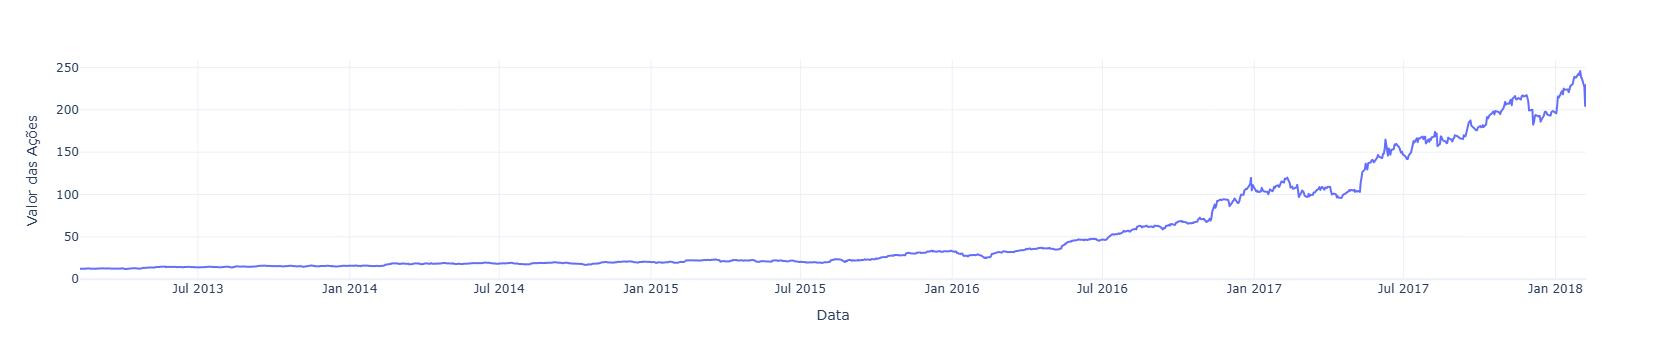

In [32]:
# Gráfico para visualização da série ao longo do tempo
fig = px.line(data_frame= data, x = data.index, y = 'open')
fig.update_layout(xaxis_title = "Data", yaxis_title = "Valor das Ações",
                 template = "plotly_white", hovermode = "x unified")
fig.show()

In [7]:
scaler = MinMaxScaler(feature_range=(0.0,1.0))
scaled_data = scaler.fit_transform(price)

In [8]:
scaled_data[-10:]

array([[0.96675225],
       [0.96726573],
       [0.98703466],
       [0.98005991],
       [1.        ],
       [0.96897732],
       [0.96247326],
       [0.91968335],
       [0.82297818],
       [0.93072315]])

In [9]:
# Função para preparação dos dados
def prepare_data(data):
    timesteps = 90 # Vamos usar 90 passos no tempo para previsão dos valores
    length = len(data)
    train = []
    test = []
    for i in range(timesteps, length):
        train.append(data[i - timesteps: i,0])
        test.append(data[i,0])
    return np.array(train), np.array(test)

In [10]:
X,y = prepare_data(scaled_data)

In [11]:
# Separação de 80% dos dados para treino
length = int(len(scaled_data) * 0.8)
idx = data.index[(length + 90) :] # Separação dos índices para plotagem dos gráficos
X_train = X[: length]
X_test = X[length :]
y_train = y[: length]
y_test = y[length :]
X_train.shape

(1007, 90)

In [12]:
print(y_test.shape)

(162,)


In [13]:
#Redimensionamento dos dados para formato aceito pela rede neural
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
X_train.shape

(1007, 90, 1)

### Definição da estrutura e treinamento da rede Naural

Vamos usar camadas GRU.... 
Sua estrutura mais simples se mostrou mais eficiente para esse caso específico

In [34]:
# Estrutura da rede com 5 camadas recorrentes e uma camada totalmente conectada além de camadas de dropout para minimizar o overfitting
modelo = Sequential()
modelo.add(GRU(100, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelo.add(Dropout(0.2))
modelo.add(GRU(100, return_sequences=True))
modelo.add(Dropout(0.2))
modelo.add(GRU(100, return_sequences=True))
modelo.add(Dropout(0.2))
modelo.add(GRU(100, return_sequences=True))
modelo.add(Dropout(0.2))
modelo.add(GRU(100, return_sequences=False))
modelo.add(Dropout(0.2))
modelo.add(Dense(1))

Definimos também uma condição de parada caso a perda não esteja diminuindo com restauração dos melhores pesos da rede

In [15]:
es = EarlyStopping(monitor = "val_loss", patience = 20, restore_best_weights = True)
modelo.compile(optimizer = "adam", loss = "mean_squared_error")
history = modelo.fit(X_train, y_train, epochs = 50, batch_size = 8, callbacks = es, validation_data=(X_test, y_test))

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 130ms/step - loss: 0.0051 - val_loss: 0.0015
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - loss: 0.0017 - val_loss: 0.0048
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - loss: 7.3576e-04 - val_loss: 0.0105
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - loss: 8.2977e-04 - val_loss: 0.0016
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - loss: 8.3989e-04 - val_loss: 0.0078
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - loss: 9.4462e-04 - val_loss: 0.0084
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - loss: 8.1956e-04 - val_loss: 0.0136
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - loss: 6.2285e-04 - val_loss: 0.0024
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - loss: 7.6721e-04 - val_loss: 0.0020
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - loss: 5.9584e-04 - val_

### Avaliação do Modelo e plotagem da previsão

In [16]:
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 90, 100)        │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 90, 100)        │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 90, 100)        │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 90, 100)        │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 820,205 (3.13 MB)

 Trainable params: 273,401 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 546,804 (2.09 MB)

Text(0.5, 0, 'Epochs')

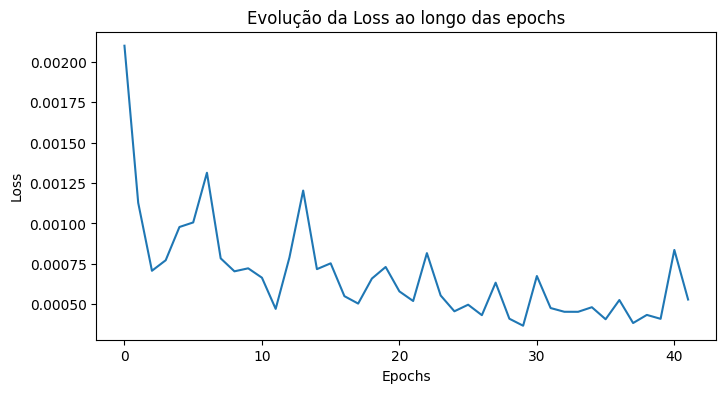

In [35]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.title("Evolução da Loss ao longo das epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")

In [18]:
y_pred = modelo.predict(X_test)
y_pred[:10]

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step


array([[0.60634655],
       [0.61033726],
       [0.62041503],
       [0.62659943],
       [0.6322013 ],
       [0.63449824],
       [0.6310475 ],
       [0.62335545],
       [0.615177  ],
       [0.61153704]], dtype=float32)

In [19]:
#Algumas métricas para avaliação do modelo
loss = modelo.evaluate(X_train, y_train, verbose=0)
loss1 = modelo.evaluate(X_test, y_test, verbose=0)
print("Erro com dados de treino MSE {:.2f} RMSE ({:.2f})".format(loss, np.sqrt(loss)))
print("Erro com dados de teste MSE {:.2f} RMSE({:.2f})".format(loss1, np.sqrt(loss1)))

Erro com dados de treino MSE 0.00 RMSE (0.01)
Erro com dados de teste MSE 0.00 RMSE(0.03)


As métricas indicam um bom ajuste do modelo tanto nos dados de teste quanto nos dados de validação

In [20]:
y_pred = scaler.inverse_transform(np.array(y_pred.reshape(-1,1)))
y_test = scaler.inverse_transform(np.array(y_test.reshape(-1,1)))
y_test[:10]

array([[153.41],
       [159.03],
       [158.21],
       [159.8 ],
       [158.68],
       [155.16],
       [151.44],
       [149.32],
       [150.6 ],
       [147.38]])

In [21]:
print(len(y_test))
print(len(y_pred))

162
162


Podemos ver graficamente que a rede neural conseguiu captar bem os padrões e tendências da série tanto ascendentes quanto descendentes...
Os padrões indicam que após as quedas na série há uma certa tendência ascendente da série ultrapassando os valores anteriores e continuando em uma tendência linear de valorização das ações

Text(0, 0.5, 'Valor das Ações')

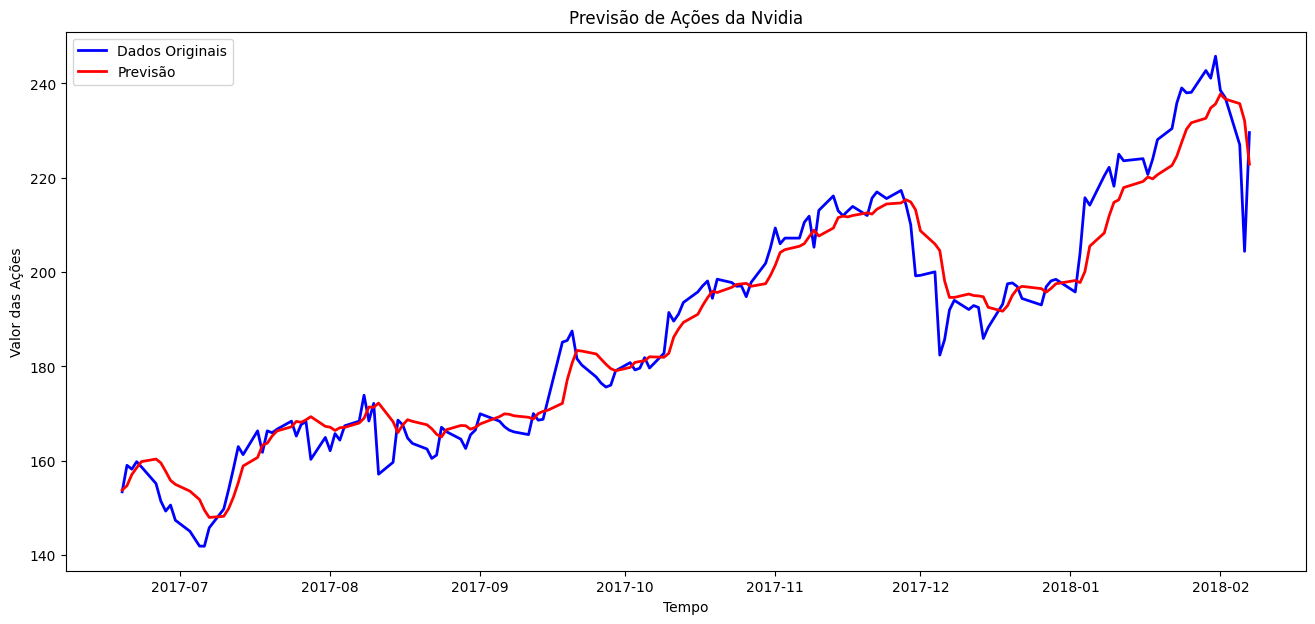

In [38]:
plt.plot(idx, y_test, color= "blue", label = "Dados Originais", linestyle = "solid", linewidth = 2.0)
plt.plot(idx, y_pred, color = "red", label = "Previsão", linestyle = "solid", linewidth = 2.0)
plt.legend()
plt.title("Previsão de Ações da Nvidia")
plt.xlabel("Tempo")
plt.ylabel("Valor das Ações")

### Previsão para o futuro

Com o modelo devidamente treinado e validado podemos fazer previsões para o futuro utilizando o modelo com os últimos dados conhecidos da série...
Cada novo dado previsto é usado para alimentar o modelo para previsões futuras... 
Para isso vamos utilizar um laço onde cada nova previsão é utilizada como passo de tempo mais recente e descartamos o passo mais antigo, isso nos permite prever quantos passos a frente nós quisermos

In [23]:
#Laço para previsão dos próximos valores
steps = 90
window_data = X_test[-1]
predictions = []
for _ in range(12): # dias previstos
    window_data = np.reshape(window_data,(1,steps,1))
    prediction = modelo.predict(window_data, verbose=0)
    predictions.append(prediction[0][0])
    window_data = window_data[:,1:,:]
    window_data = np.append(window_data, [prediction], axis = 1)
predictions = np.array(predictions)
print(predictions)

[0.90206695 0.9021665  0.9039339  0.90419894 0.9038757  0.9033706
 0.90281034 0.9022316  0.9016439  0.9010517  0.9004577  0.899865  ]


In [24]:
pred = scaler.inverse_transform(predictions.reshape(-1,1))

Visualização Gráfica dos valores futuros

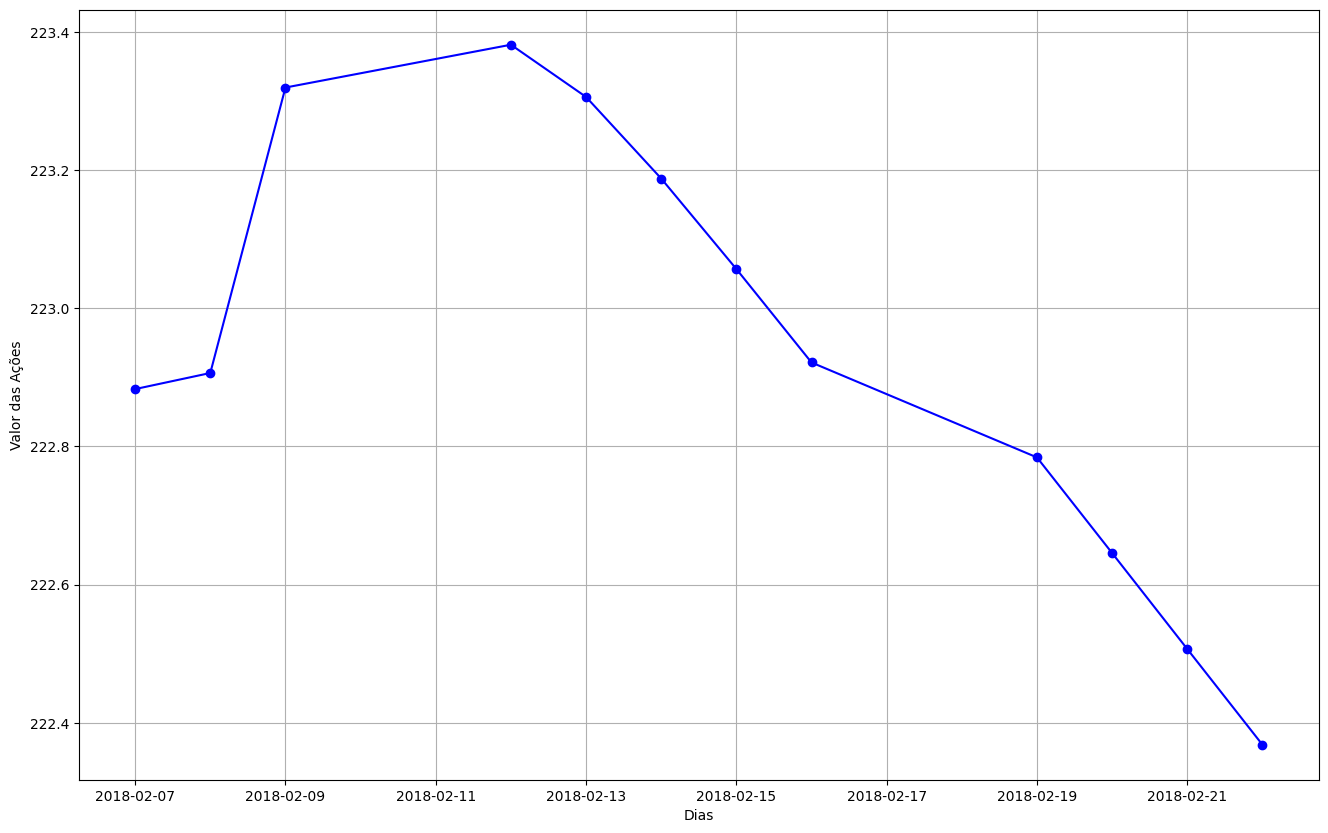

In [25]:
future_index = pd.date_range(start=idx[-1], periods = len(pred), freq="B")
plt.plot(future_index, pred, color = "blue", marker = 'o')
plt.xlabel("Dias")
plt.ylabel("Valor das Ações")
plt.grid(True)
plt.show()